In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ngwl-predict-customer-churn/sample_submission.csv
/kaggle/input/ngwl-predict-customer-churn/sample_submission_from_kaggle_change_sep.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-23.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-17.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-19.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-31.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-11.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-21.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-03.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-09.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-15.csv
/kaggle/input/ngwl-predict-customer-churn/line_items07/line_items_2020-07-27.csv
/kaggle/input/ngwl-predict-customer-chu

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


# Подгрузка таблиц

## User profiles

In [3]:
us_prof = pd.read_csv('/kaggle/input/ngwl-predict-customer-churn/misc/user_profiles.csv')
us_prof.head()

,user_id,gender,bdate
0,2226207,NaN,NaN
1,2226207,NaN,NaN
2,2226207,NaN,NaN
3,1684318,male,1987-10-11
4,1684318,male,1987-10-11


## Addresed

In [4]:
addr = pd.read_csv('/kaggle/input/ngwl-predict-customer-churn/misc/addresses.csv')
addr.head()

,id,phone_id
0,41,1
1,8531,2
2,2982657,2
3,3271801,2
4,3648206,2


## Shipments

In [5]:
# shps = pd.read_csv('/kaggle/input/ngwl-predict-customer-churn/shipments/shipments2020-01-01.csv')
shipments_dict = {}
for sh in os.listdir('/kaggle/input/ngwl-predict-customer-churn/shipments/'):
    shipments_dict[sh] = pd.read_csv('/kaggle/input/ngwl-predict-customer-churn/shipments/'+sh)

In [6]:
shipments = pd.concat(shipments_dict.values())
print(shipments.shape)
shipments_dict = None
shipments.head(3)

(2260686, 20)


,user_id,ship_address_id,shipment_id,order_id,order_created_at,order_completed_at,shipment_starts_at,retailer,s.order_state,shipment_state,s.city_name,s.store_id,total_cost,rate,dw_kind,promo_total,total_weight,platform,os,shipped_at
0,4077,4058639,178163,1291559,2017-05-10 10:16:41,2020-03-13 11:57:53,2020-03-15 12:00:00,METRO,canceled,canceled,Москва,1,158.0,0,courier,0.0,27610,web,windows,NaN
1,48861,271117,383088,3015822,2018-02-27 10:48:13,2020-04-24 21:09:15,2020-04-30 07:00:00,METRO,complete,shipped,Москва,3,499.0,0,courier,0.0,87806,web,windows,2020-04-30 12:53:17
2,3119,276189,385477,3019844,2018-03-01 11:58:09,2020-04-25 17:30:52,2020-04-26 12:00:00,METRO,complete,shipped,Москва,14,158.0,0,courier,0.0,23029,web,windows,2020-04-26 11:54:23


Добавим еще один ключ для соединения по месяцам

In [7]:
shipments['addr_key'] = shipments['order_completed_at'].apply(lambda x: x.split(' ')[0][:-3])

In [8]:
np.sort(shipments['addr_key'].unique())

array(['2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05',
       '2020-06', '2020-07', '2020-08'], dtype=object)

## Train

In [9]:
train = pd.read_csv('/kaggle/input/ngwl-predict-customer-churn/train/train.csv')
train.head()

,phone_id,order_completed_at,target
0,19843,2020-01,1.0
1,19843,2020-02,0.0
2,19843,2020-03,0.0
3,19843,2020-04,0.0
4,19843,2020-05,0.0


In [10]:
train.order_completed_at.unique()

array(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07'], dtype=object)

In [11]:
# Прверим баланс классов в кажом месяце
train.groupby('order_completed_at')['target'].value_counts()

order_completed_at  target
2020-01             0.0        37045
                    1.0        22607
2020-02             0.0        42145
                    1.0        33840
2020-03             0.0        58875
                    1.0        47916
2020-04             1.0        96839
                    0.0        63006
2020-05             1.0       119923
                    0.0        98646
2020-06             0.0       127797
                    1.0       126488
2020-07             0.0       151807
                    1.0       132642
Name: target, dtype: int64

Классы относительно сбалансированны, что облегчает работу с ними

## Соединение таблиц

In [12]:
tr_addr = train.merge(addr, on='phone_id', how='outer')


In [13]:
tr_ship = tr_addr.merge(shipments, left_on=['id', 'order_completed_at'],
                        right_on=['ship_address_id', 'addr_key'], how='outer')

In [14]:
tr_ship = tr_addr.merge(shipments, left_on=['id', 'order_completed_at'],
                        right_on=['ship_address_id', 'addr_key'], how='outer')

In [15]:
tr_usr = tr_ship.merge(us_prof, on=['user_id'], how='left')

In [16]:
tr_usr.loc[(tr_usr['addr_key'].isna()),'addr_key'] = tr_usr.loc[(tr_usr['addr_key'].isna()),'order_completed_at_x']

In [17]:
# Экономим память

tr_addr = None
li = None
shipments = None
shipments_dict=None
addr = None
train = None
tr_ship = None

In [18]:
# Сразу подтянем данные к sample_submition

kg_test = pd.read_csv('/kaggle/input/ngwl-predict-customer-churn/sample_submission.csv', sep=';')
print(kg_test.info())
kg_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214609 entries, 0 to 214608
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Id         214609 non-null  int64  
 1   Predicted  0 non-null       float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB
None


,Id,Predicted
0,19843,NaN
1,471287,NaN
2,342522,NaN
3,457799,NaN
4,233778,NaN


In [20]:
# Отберем только нужные для обучения строки
cols = ['phone_id','addr_key','target','gender',
        'retailer','s.order_state','shipment_state',
        's.city_name','total_cost',
        'rate','dw_kind','promo_total',
        'total_weight','platform','os']

In [21]:
kg_test_full = kg_test.merge(tr_usr[cols], left_on='Id', right_on='phone_id', how='left')

In [22]:
short = tr_usr[cols]
tr_usr = None

Обучаться будем только на данных до августа

In [23]:
train = short[short['addr_key']!='2020-08'].dropna(subset=['target'])

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11622564 entries, 0 to 11622563
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   phone_id        float64
 1   addr_key        object 
 2   target          float64
 3   gender          object 
 4   retailer        object 
 5   s.order_state   object 
 6   shipment_state  object 
 7   s.city_name     object 
 8   total_cost      float64
 9   rate            float64
 10  dw_kind         object 
 11  promo_total     float64
 12  total_weight    float64
 13  platform        object 
 14  os              object 
dtypes: float64(6), object(9)
memory usage: 1.4+ GB


In [25]:
# Заполним пропуски

filled = train.fillna({'gender':'female',
              'retailer':'no_retailer',
              's.order_state':'no_order',
              'shipment_state':'no_shipment',
              's.city_name':'no_city',
              'total_cost':0,
              'rate':0,
              'dw_kind':'no_dw',
              'promo_total':0,
              'total_weight':0,
              'platform':'no_platform',
              'os':'no_os'
             })
cat = ['gender','retailer','s.order_state','shipment_state',
       's.city_name','dw_kind','platform','os']
num = ['s.store_id','total_cost','rate','promo_total','total_weight']

In [26]:
num_orders = train[train['s.order_state']=='complete'].groupby(
    ['addr_key','phone_id'], as_index=False)[['s.order_state']].count()

Закодируем категориальные данные

In [27]:
encoder = OrdinalEncoder()
encoder.fit(filled[cat])

OrdinalEncoder()

In [28]:
filled[cat] = encoder.transform(filled[cat])

Сгруппируем данные по месяцем и пользователям, чтобы можно было предсказывать для одного человека

In [29]:
grouped = filled.groupby(['addr_key','phone_id'], as_index=False).median()

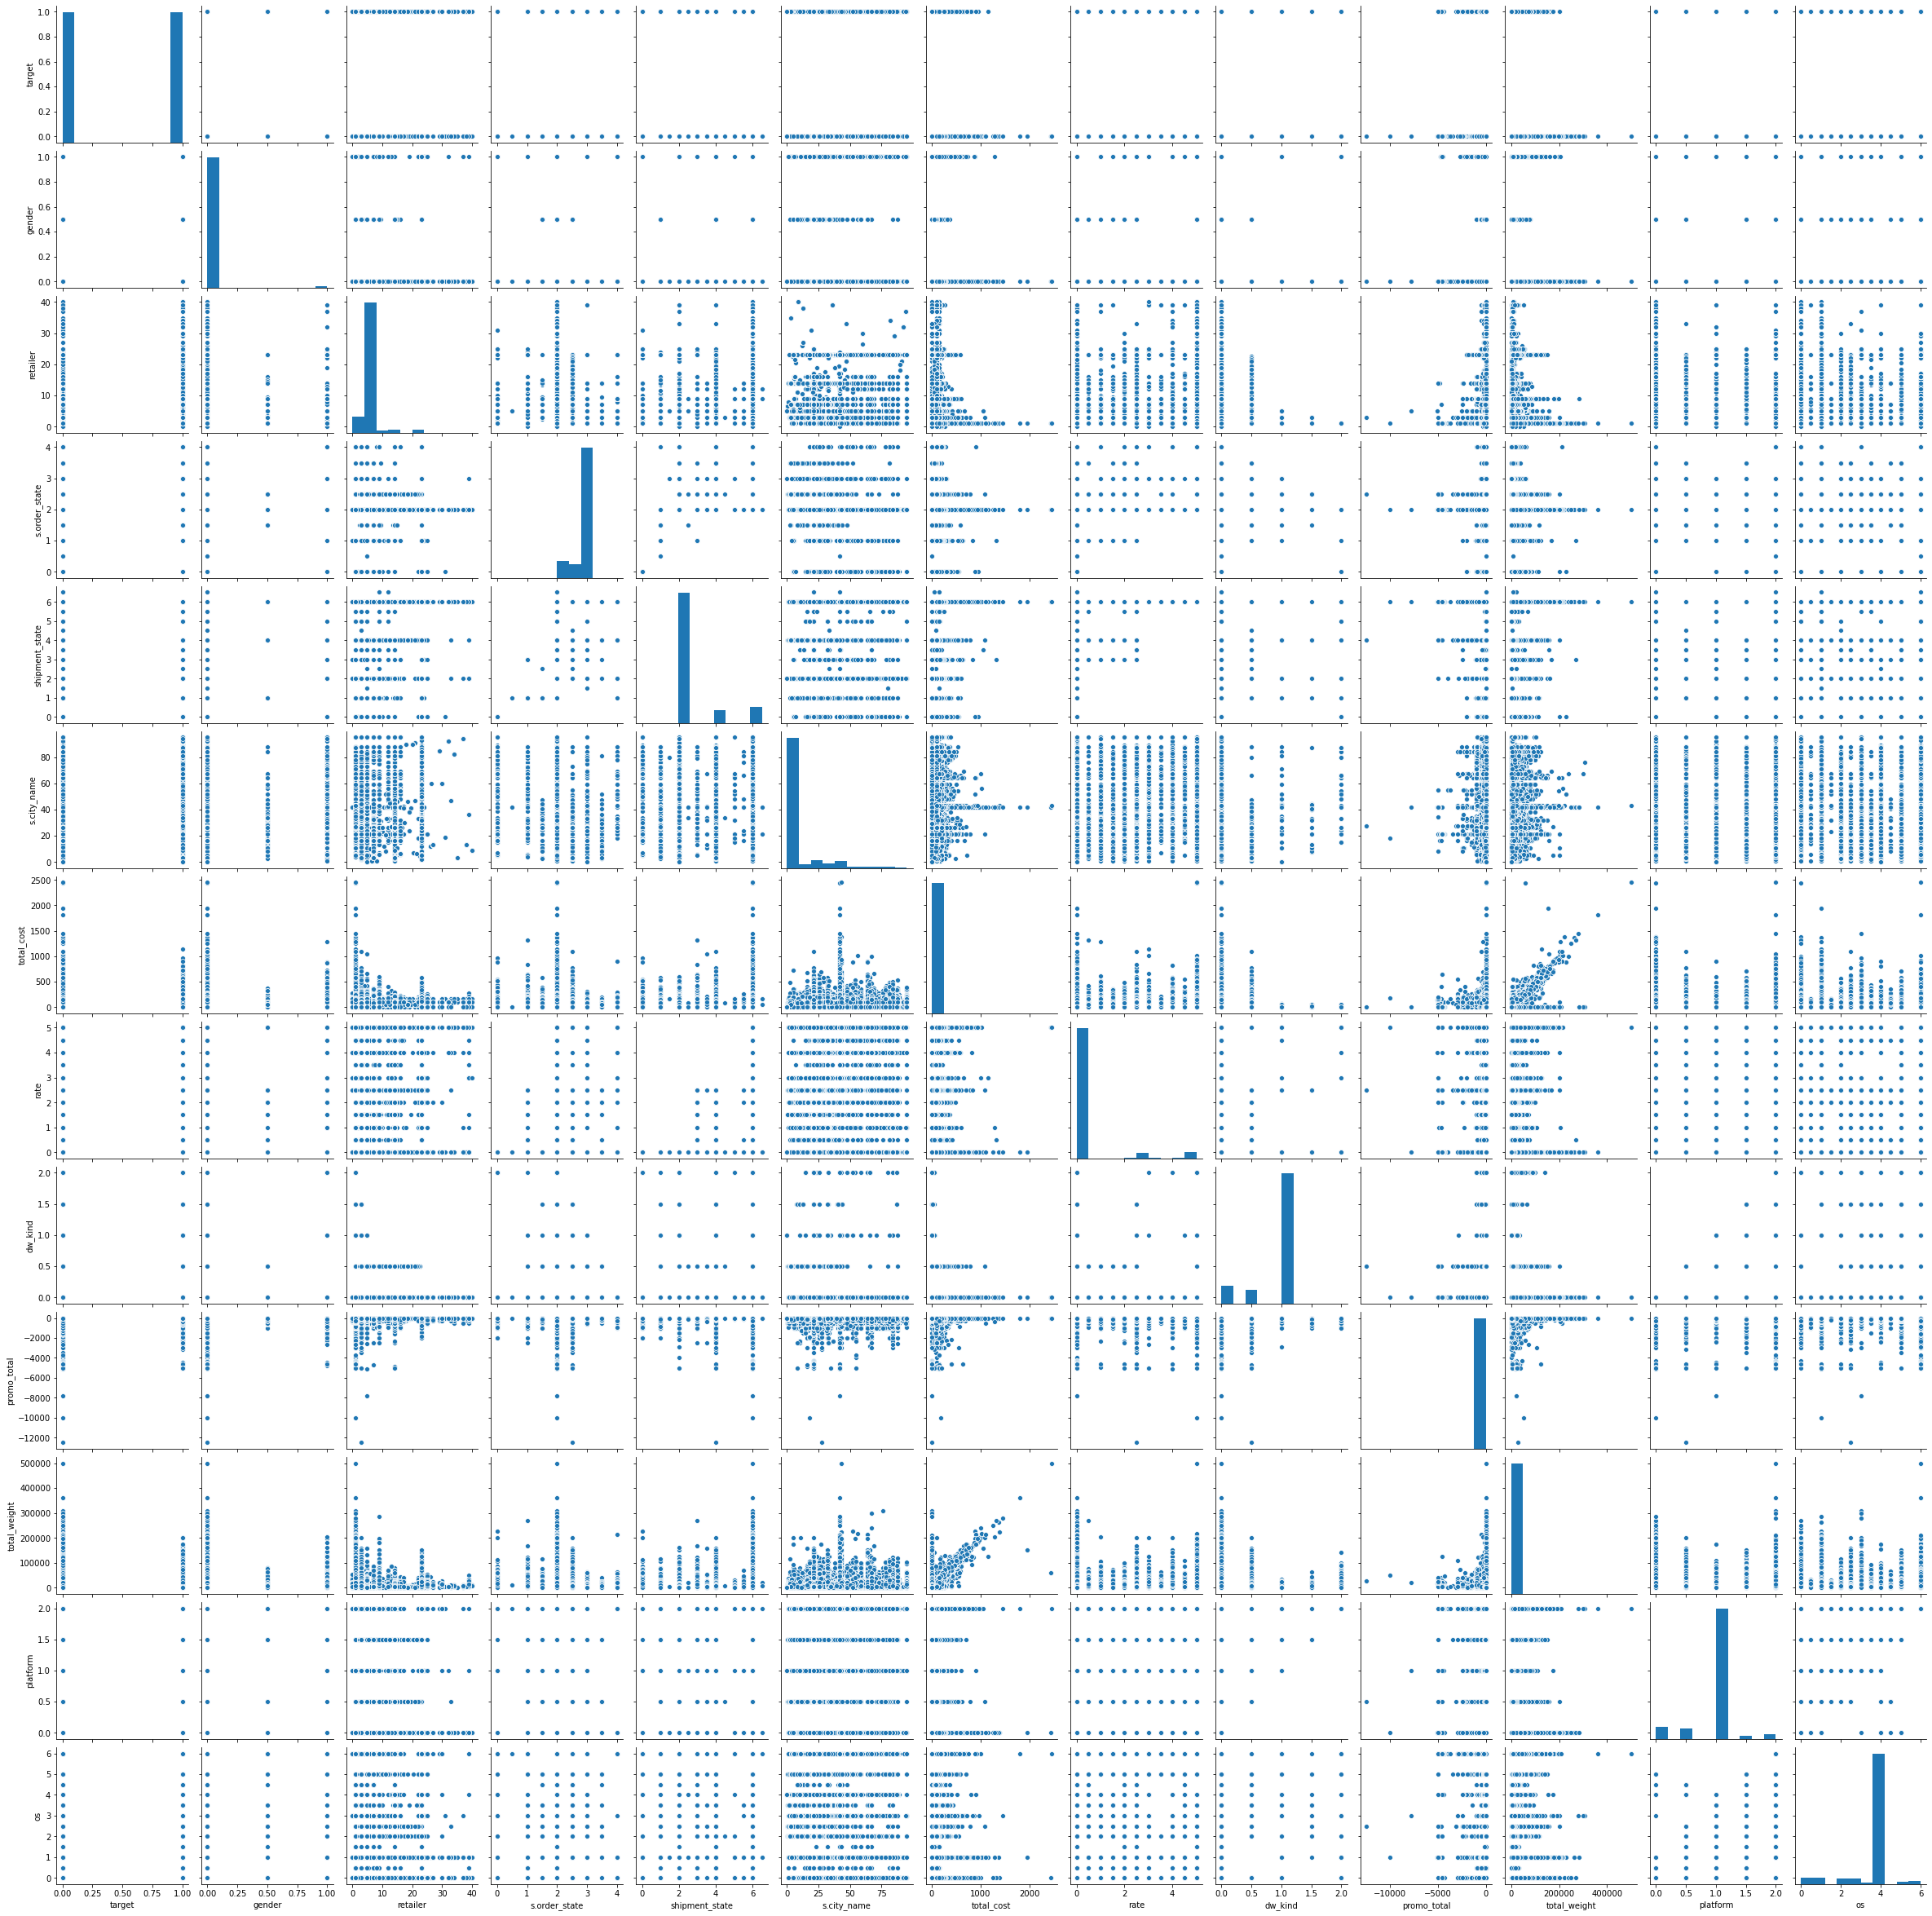

In [31]:
sns.pairplot(grouped.drop(['addr_key','phone_id'], axis=1), hue_order='target',palette = 'Accent')

Добавим данные о количестве завершенных заказов в месяце

In [33]:
num_orders = num_orders.rename(columns={'s.order_state':'num_orders'})
grouped = grouped.merge(num_orders, how='left').fillna(0)

# Обучение модели

Делим выборку на трейн и тест

In [62]:
X = grouped[grouped['addr_key']!='2020-07'].drop(['target','addr_key','phone_id'], axis=1)
y = grouped[grouped['addr_key']!='2020-07']['target']

In [63]:
X_test = grouped[grouped['addr_key']=='2020-07'].drop(['target','addr_key','phone_id'], axis=1)
y_test = grouped[grouped['addr_key']=='2020-07']['target']

In [78]:
params = {'learning_rate': 0.01, 'depth': 8, 'n_estimators': 200, 'class_weights': [1.5, 1],'eval_metric':'F1'}

clf = CatBoostClassifier(**params)

In [79]:
clf.fit(X,y)

0:	learn: 0.6724589	total: 264ms	remaining: 52.4s
1:	learn: 0.6724602	total: 494ms	remaining: 48.9s
2:	learn: 0.6729701	total: 740ms	remaining: 48.6s
3:	learn: 0.6733747	total: 997ms	remaining: 48.9s
4:	learn: 0.6729185	total: 1.24s	remaining: 48.4s
5:	learn: 0.6730341	total: 1.49s	remaining: 48.2s
6:	learn: 0.6720282	total: 1.74s	remaining: 48.1s
7:	learn: 0.6721927	total: 2s	remaining: 48s
8:	learn: 0.6728801	total: 2.26s	remaining: 47.9s
9:	learn: 0.6726199	total: 2.5s	remaining: 47.5s
10:	learn: 0.6726238	total: 2.74s	remaining: 47.1s
11:	learn: 0.6727188	total: 2.98s	remaining: 46.6s
12:	learn: 0.6727374	total: 3.21s	remaining: 46.3s
13:	learn: 0.6727344	total: 3.45s	remaining: 45.8s
14:	learn: 0.6726267	total: 3.69s	remaining: 45.5s
15:	learn: 0.6726162	total: 3.92s	remaining: 45.1s
16:	learn: 0.6726250	total: 4.16s	remaining: 44.8s
17:	learn: 0.6726094	total: 4.39s	remaining: 44.4s
18:	learn: 0.6726560	total: 4.61s	remaining: 43.9s
19:	learn: 0.6726554	total: 4.85s	remaining: 43

161:	learn: 0.6746391	total: 39.8s	remaining: 9.33s
162:	learn: 0.6746307	total: 40s	remaining: 9.08s
163:	learn: 0.6745894	total: 40.2s	remaining: 8.83s
164:	learn: 0.6745743	total: 40.4s	remaining: 8.58s
165:	learn: 0.6745951	total: 40.7s	remaining: 8.33s
166:	learn: 0.6745749	total: 40.9s	remaining: 8.09s
167:	learn: 0.6746010	total: 41.2s	remaining: 7.84s
168:	learn: 0.6745991	total: 41.4s	remaining: 7.6s
169:	learn: 0.6746202	total: 41.7s	remaining: 7.35s
170:	learn: 0.6747046	total: 41.9s	remaining: 7.11s
171:	learn: 0.6747352	total: 42.1s	remaining: 6.86s
172:	learn: 0.6747214	total: 42.3s	remaining: 6.61s
173:	learn: 0.6747507	total: 42.6s	remaining: 6.36s
174:	learn: 0.6747705	total: 42.8s	remaining: 6.12s
175:	learn: 0.6748139	total: 43.1s	remaining: 5.88s
176:	learn: 0.6748681	total: 43.4s	remaining: 5.63s
177:	learn: 0.6748343	total: 43.6s	remaining: 5.39s
178:	learn: 0.6748476	total: 43.9s	remaining: 5.14s
179:	learn: 0.6748416	total: 44.1s	remaining: 4.9s
180:	learn: 0.67

In [80]:
X_test = grouped[grouped['addr_key']=='2020-07'].drop(['target','addr_key','phone_id'], axis=1)
y_test = grouped[grouped['addr_key']=='2020-07']['target']

Выберем трешхолд, по которому будем разделять на отто и не отток

In [81]:
pred_prob = clf.predict_proba(X_test)

In [85]:
for tresh in [0.35,0.4,0.3]:
    print(f1_score(y_test, [1 if x>=tresh else 0 for x in pred_prob[:,1]]))

0.7162198327534819
0.7041246813160132
0.7163150471814707


Посомтрим на самые важные признаки для модели

In [42]:
dict(zip(X.columns,clf.get_feature_importance()))

{'gender': 0.008029905630034228,
 'retailer': 0.18200508152883352,
 's.order_state': 3.9736361228804227,
 'shipment_state': 7.08383153745236,
 's.city_name': 1.833697204307344,
 'total_cost': 8.47396523667155,
 'rate': 0.750802362171708,
 'dw_kind': 2.5597035253288176,
 'promo_total': 0.09081413046736117,
 'total_weight': 1.0539604775267994,
 'platform': 0.42667566813379454,
 'os': 0.2667721356228846,
 'num_orders': 73.29610661227808}

In [43]:
preds = clf.predict(X_test)

In [44]:
f1_score(y_test,preds)

0.715857689631176

Сделаем прогноз на тестовых данных kaggle

In [45]:
fin_test = kg_test.merge(grouped.drop('target', axis=1),left_on='Id', right_on='phone_id', how='left')

In [46]:
fill_dict = dict(fin_test.drop(['Id','Predicted','phone_id'],axis=1).mean())

In [47]:
X_tst = fin_test.groupby(['Id'], as_index=False, sort=False).mean().iloc[:,3:].fillna(fill_dict)

In [48]:
preds_prob = clf.predict_proba(X_tst)
preds = [1 if x>=0.65 else 0 for x in preds_prob[:,1]]
pd_stacked = np.vstack(preds)

In [49]:
preds_final = pd.concat([kg_test,pd.DataFrame(pd_stacked, columns=['Prediction'])],axis=1)
preds_final.Predicted = preds_final.Prediction
preds_final = preds_final.drop('Prediction', axis=1)

In [57]:
preds_final.Predicted.value_counts()

1    160826
0     53783
Name: Predicted, dtype: int64

In [50]:
preds_final

In [56]:
preds_final.Predicted = preds_final.Predicted.astype('int')
preds_final.to_csv('submission7.csv',  index=False)